In [1]:
!pip install mxnet-cu100mkl

     |████████████████████████████████| 576.6MB 29kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


#MXNet

In [2]:
import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn
import matplotlib.pyplot as plt

ctx = mx.gpu() if mx.context.num_gpus() else mx.cpu()

print('ctx:', ctx)

ctx: gpu(0)


##Getting the dataset

In [3]:
def transform(features, _):
    return features.transpose((2, 0, 1)).astype('float32')/255.0

true_data = gluon.data.vision.MNIST(train = True, transform = transform)

image.shape: (1, 28, 28)


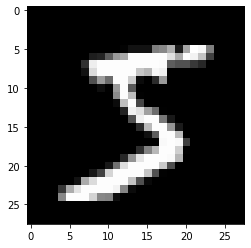

In [4]:
image = true_data[0]

print('image.shape:', image.shape)

plt.imshow(image[0].asnumpy(), 'gray')
plt.show()

##Defining Dataloaders

In [5]:
batch_size = 64
train_data = gluon.data.DataLoader(true_data, batch_size = batch_size, shuffle = True)

print(f'No of Batches in training data: {len(train_data)}')

No of Batches in training data: 938


##Building Discriminator and Generator

In [6]:
class Discriminator(nn.HybridBlock):
    def __init__(self):
        super(Discriminator, self).__init__()
        with self.name_scope():
            self.conv1 = nn.Conv2D(64, 3, 1)
            self.batchnorm1 = nn.BatchNorm()
            self.activation1 = nn.LeakyReLU(0.1)
            self.maxpool1 = nn.MaxPool2D()

            self.conv2 = nn.Conv2D(128, 3, 1)
            self.batchnorm2 = nn.BatchNorm()
            self.activation2 = nn.LeakyReLU(0.1)
            self.maxpool2 = nn.MaxPool2D()

            self.flatten = nn.Flatten()

            self.dense1 = nn.Dense(256)
            self.batchnorm3 = nn.BatchNorm()
            self.activation3 = nn.LeakyReLU(0.1)

            self.dense2 = nn.Dense(1, 'sigmoid')

    def hybrid_forward(self, F, x):
        layer = self.maxpool1(self.activation1((self.batchnorm1(self.conv1(x)))))
        layer = self.maxpool2(self.activation2((self.batchnorm2(self.conv2(layer)))))
        layer = self.flatten(layer)
        layer = self.activation3(self.batchnorm3(self.dense1(layer)))
        layer = self.dense2(layer)
        return layer


class Generator(nn.HybridBlock):
    def __init__(self):
        super(Generator, self).__init__()
        with self.name_scope():
            self.dense1 = nn.Dense(128 * 4 * 4)
            self.batchnorm1 = nn.BatchNorm()
            self.activation1 = nn.LeakyReLU(0.1)

            self.reshape = nn.HybridLambda(lambda F, x: x.reshape((-1, 128, 4, 4)))
            
            self.deconv1 = nn.Conv2DTranspose(64, 4, 1, 0)
            self.batchnorm2 = nn.BatchNorm()
            self.activation2 = nn.LeakyReLU(0.1)

            self.deconv2 = nn.Conv2DTranspose(32, 4, 2, 1)
            self.batchnorm3 = nn.BatchNorm()
            self.activation3 = nn.LeakyReLU(0.1)

            self.deconv3 = nn.Conv2DTranspose(1, 4, 2, 1, activation = 'sigmoid')
    
    def hybrid_forward(self, F, z):
        z = z.expand_dims(2).expand_dims(2) # reshaping z from shape (-1, 100) to (-1, 100, 1, 1) i.e. 100 channels with hight and width of 1, 1
        layer = self.activation1(self.batchnorm1(self.dense1(z)))
        layer = self.reshape(layer)
        layer = self.activation2(self.batchnorm2(self.deconv1(layer)))
        layer = self.activation3(self.batchnorm3(self.deconv2(layer)))
        layer = self.deconv3(layer)
        return layer


discriminator = Discriminator()
discriminator.initialize(ctx = ctx, init = mx.init.Uniform())
discriminator.hybridize()

generator = Generator()
generator.initialize(ctx = ctx, init = mx.init.Uniform())
generator.hybridize()

print(discriminator)
print(generator)

Discriminator(
  (conv1): Conv2D(None -> 64, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (activation1): LeakyReLU(0.1)
  (maxpool1): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (conv2): Conv2D(None -> 128, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm2): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (activation2): LeakyReLU(0.1)
  (maxpool2): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (flatten): Flatten
  (dense1): Dense(None -> 256, linear)
  (batchnorm3): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (activation3): LeakyReLU(0.1)
  (dense2): Dense(None -> 1, Activation(sigmoid))
)
Generator(
  (dense1): Dense

## Checking output shapes

In [7]:
x = nd.random.normal(0, 1, (1, 1, 28, 28), ctx = ctx)
z = nd.random.normal(0, 1, (1, 100), ctx = ctx)

true = discriminator(x)
generated = generator(z)

print(true.shape, generated.shape)

(1, 1) (1, 1, 28, 28)


##Objective Losses

In [0]:
def discriminator_loss(true, false):
    return -nd.mean(nd.log(true) + nd.log(1 - false))

def generator_loss(false):
    return -nd.mean(nd.log(false))

## Defining Optimizers

In [0]:
generator_optimizer = mx.optimizer.Adam(0.001)
discriminator_optimizer = mx.optimizer.Adam(0.001)

generator_trainer = gluon.Trainer(generator.collect_params(), generator_optimizer)
discriminator_trainer = gluon.Trainer(discriminator.collect_params(), discriminator_optimizer)

## Training the model

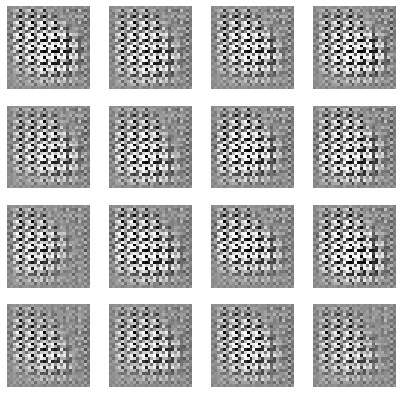

Batch: 300


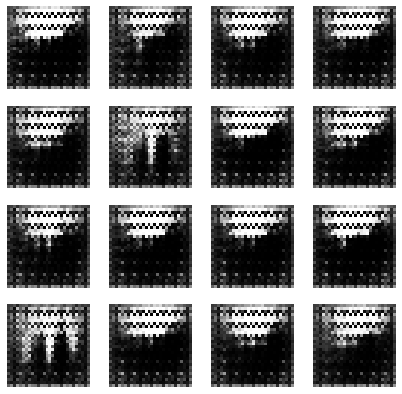

Batch: 600


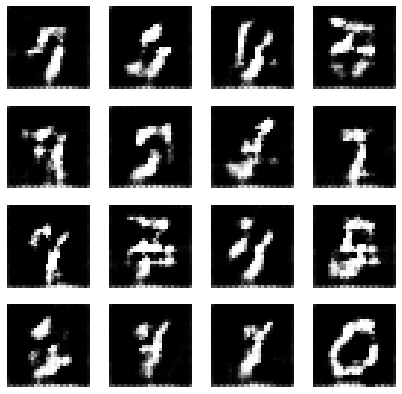

Batch: 900

Epoch: 1
Generator Loss: 2.4575
Discriminator Loss: 0.41950


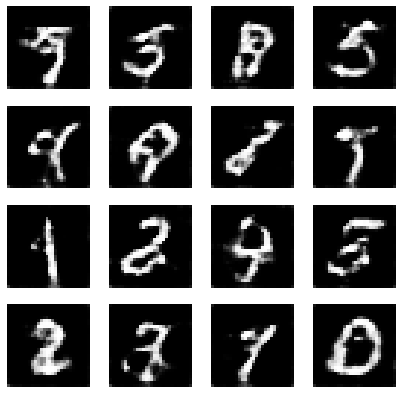

Batch: 300


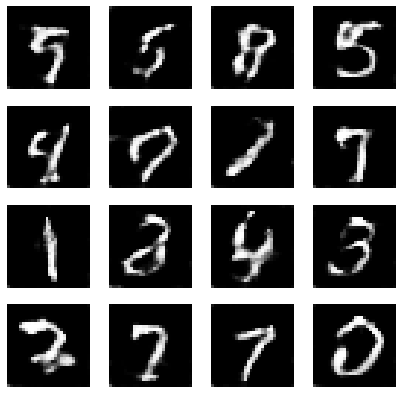

Batch: 600


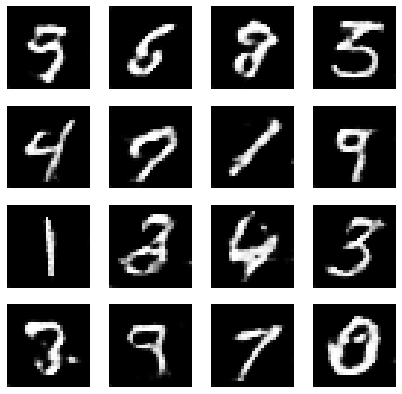

Batch: 900

Epoch: 2
Generator Loss: 2.153
Discriminator Loss: 0.57249


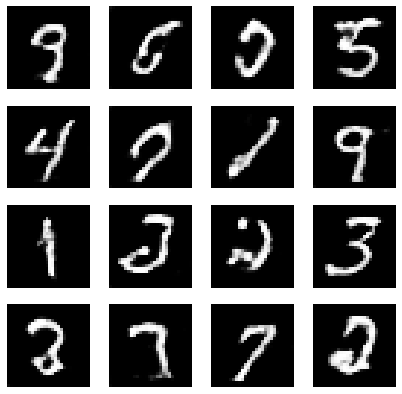

Batch: 300


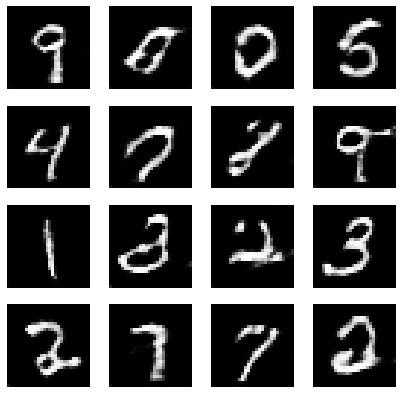

Batch: 600


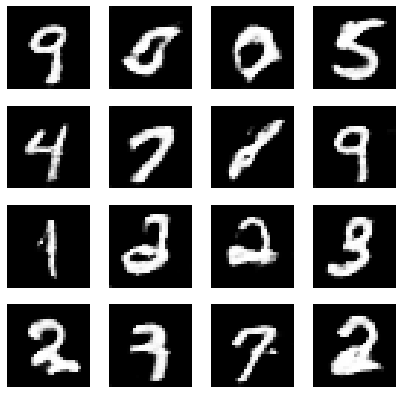

Batch: 900

Epoch: 3
Generator Loss: 2.3848
Discriminator Loss: 0.52223


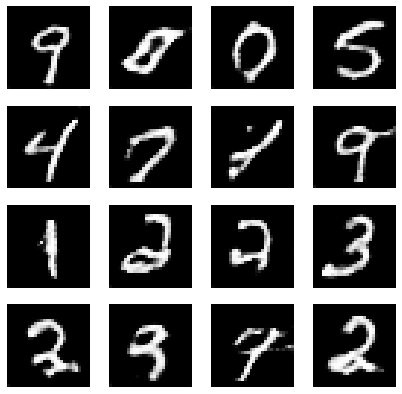

Batch: 300


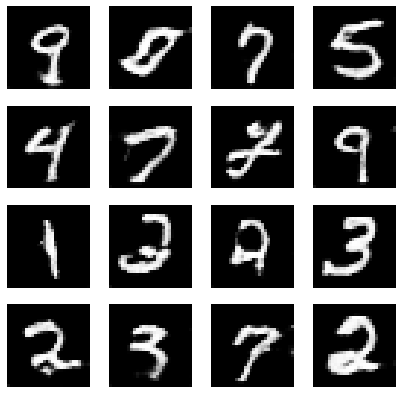

Batch: 600


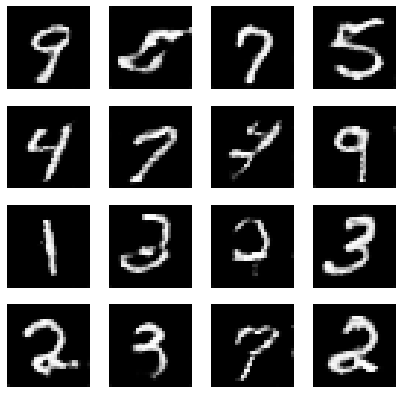

Batch: 900

Epoch: 4
Generator Loss: 2.7413
Discriminator Loss: 0.43908


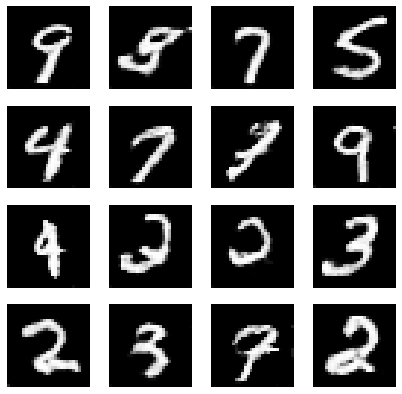

Batch: 300


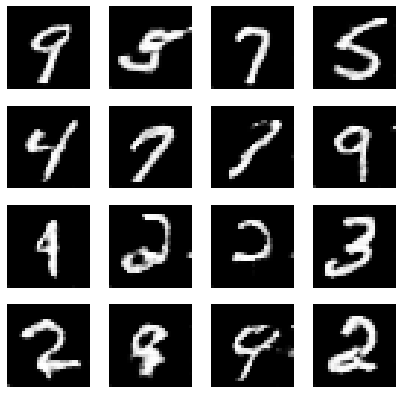

Batch: 600


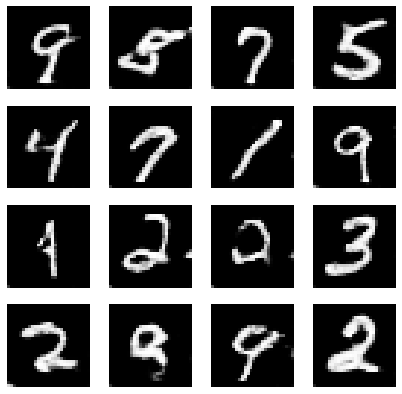

Batch: 900

Epoch: 5
Generator Loss: 3.0272
Discriminator Loss: 0.39029


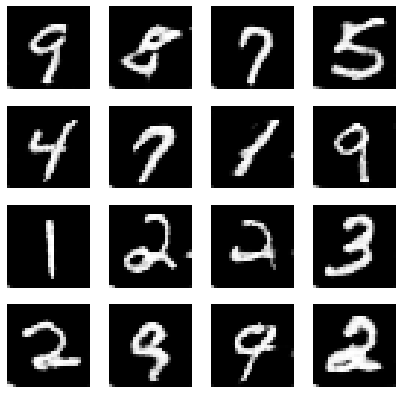

Batch: 300


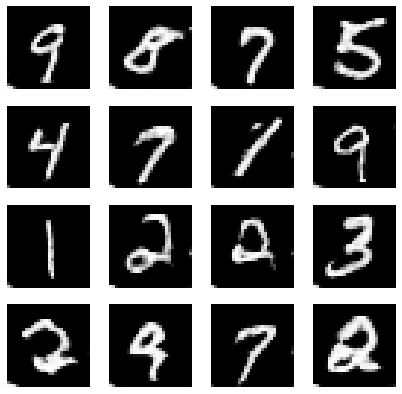

Batch: 600


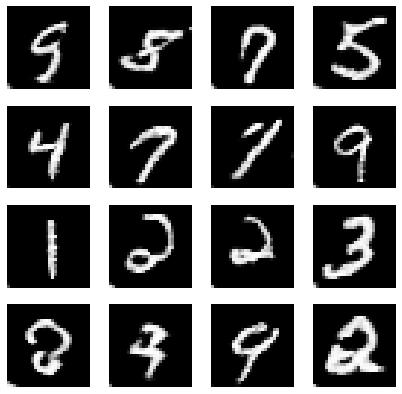

Batch: 900

Epoch: 6
Generator Loss: 3.3418
Discriminator Loss: 0.33038


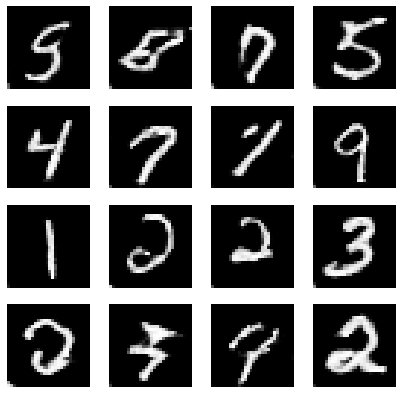

Batch: 300


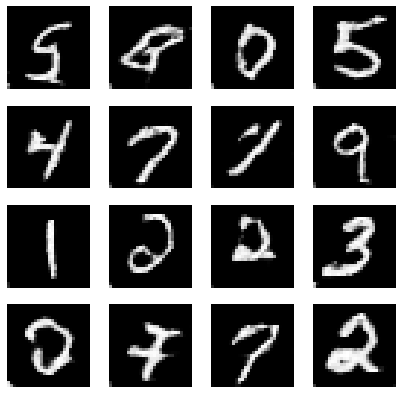

Batch: 600


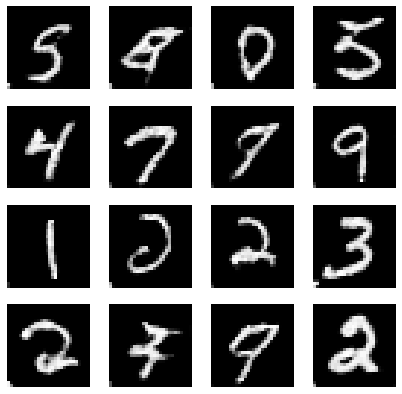

Batch: 900

Epoch: 7
Generator Loss: 3.7685
Discriminator Loss: 0.27416


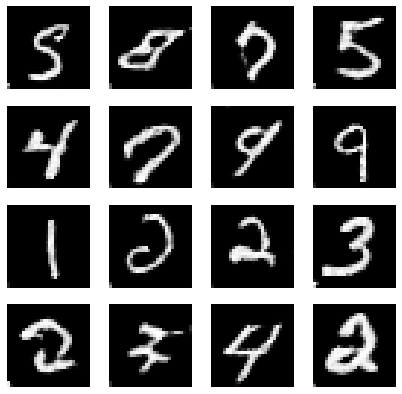

Batch: 300


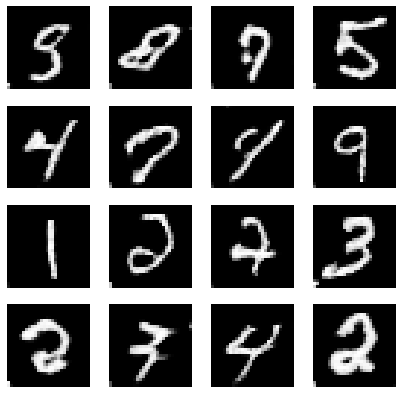

Batch: 600


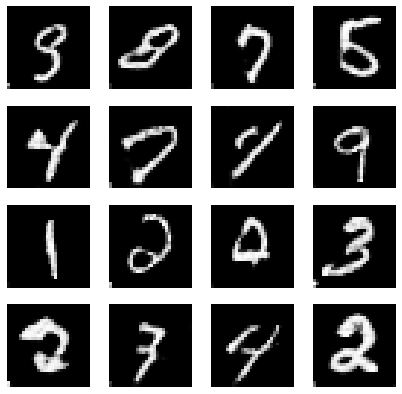

Batch: 900

Epoch: 8
Generator Loss: 4.1491
Discriminator Loss: 0.22037


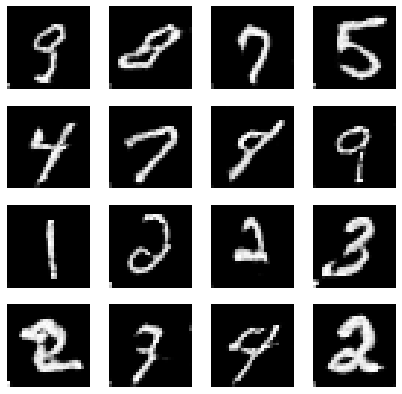

Batch: 300


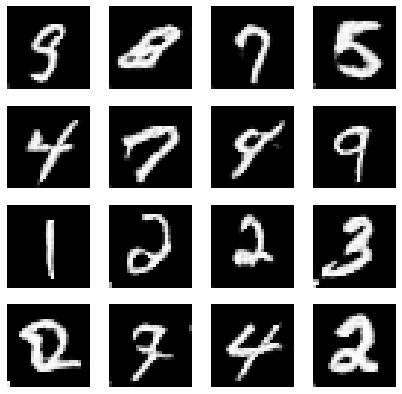

Batch: 600


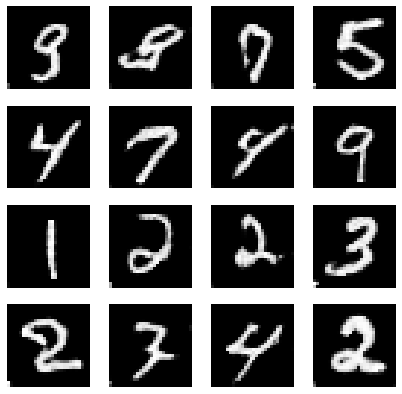

Batch: 900

Epoch: 9
Generator Loss: 4.4988
Discriminator Loss: 0.21370


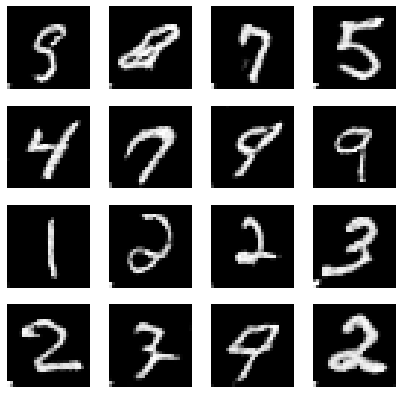

Batch: 300


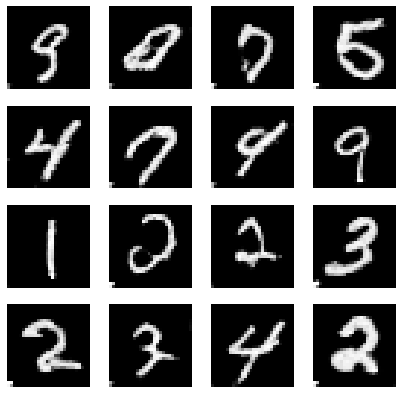

Batch: 600


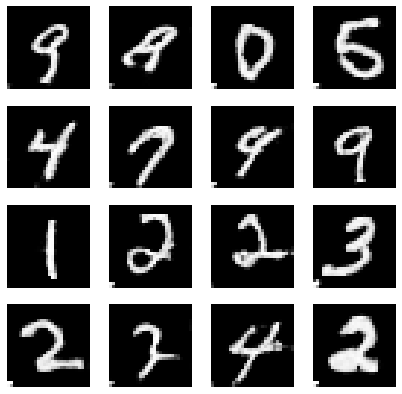

Batch: 900

Epoch: 10
Generator Loss: 4.9387
Discriminator Loss: 0.16264


In [10]:
epochs = 10

Dlosses = []
Glosses = []

z = nd.random.normal(loc = 0, scale = 1, shape = (16, 100)).as_in_context(ctx)

for epoch in range(epochs):
    dcum_loss = 0.0
    gcum_loss = 0.0

    for i, features in enumerate(train_data):
        features = features.as_in_context(ctx)
        noise = nd.random.normal(0, 1, (features.shape[0], 100), ctx = ctx)

        with autograd.record():
            true = discriminator(features)
            generated = generator(noise)
            false = discriminator(generated)
            d_loss = discriminator_loss(true, false)
        d_loss.backward()
        discriminator_trainer.step(batch_size)
        
        with autograd.record():
            generated = generator(noise)
            false = discriminator(generated)
            g_loss = generator_loss(false)
        g_loss.backward()
        generator_trainer.step(batch_size)
        
        dcum_loss += d_loss
        gcum_loss += g_loss

        if (i + 1) % 300 == 0:
            Dloss = dcum_loss.asscalar()/(i + 1)
            Gloss = gcum_loss.asscalar()/(i + 1)
            
            Dlosses.append(Dloss)
            Glosses.append(Gloss)

            plt.figure(figsize = (7, 7))
            generated = generator(z)
            for j, gen in enumerate(generated, 1):
                plt.subplot(4, 4, j)
                plt.imshow(gen[0, :, :].asnumpy(), 'gray')
                plt.axis('off')
            plt.show()
            print(f'Batch: {i + 1}')

    print(f'\nEpoch: {epoch + 1}')
    print(f'Generator Loss: {Gloss:.5}')
    print(f'Discriminator Loss: {Dloss:.5f}')

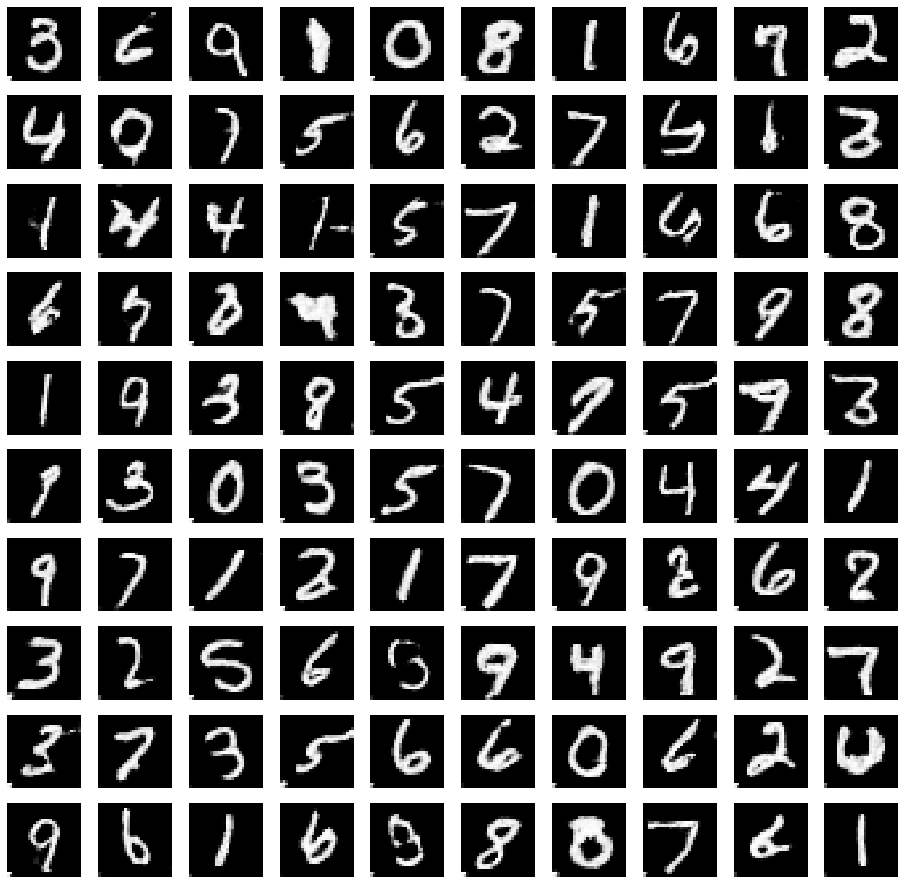

In [13]:
noise = nd.random.normal(0, 1, (100, 100)).as_in_context(ctx)

generated = generator(noise)

plt.figure(figsize = (16, 16))
for i, image in enumerate(generated):
    plt.subplot(10, 10, i + 1)
    plt.imshow(image[0, :, :].asnumpy(), 'gray')
    plt.axis('off')
plt.show()

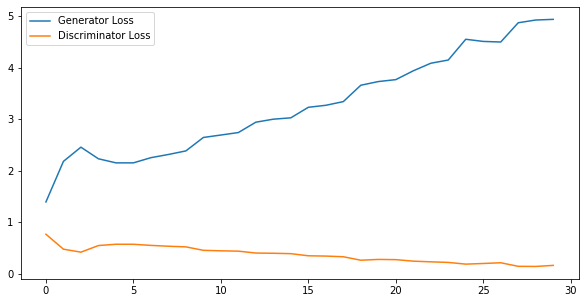

In [14]:
plt.figure(figsize = (10, 5))
plt.plot(Glosses, label = 'Generator Loss')
plt.plot(Dlosses, label = 'Discriminator Loss')
plt.legend()
plt.show()